# Lab5 - Training Deep Convolutional Neural Network
- Name1, Student's ID1
- Name2, Student's ID2
- Name3, Student's ID3

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use MNIST and Cat vs Dog dataset.

See http://yann.lecun.com/exdb/mnist <br>
See https://www.kaggle.com/c/dogs-vs-cats/data

In [68]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# %load _utils
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

### 1. Load MNIST dataset 

In [90]:
### Load dataset ###
(X_train,y_train), (X_test,y_test) = mnist.load_data()
####################

In [92]:
X_train.shape

(60000, 28, 28)

### 2. Preprocess data 

In [27]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    data = data.astype('float32')/255.
    return data

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [28]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [ ]:
BATCH_SIZE = 32

### 3. Build a convolutional neural network 
Try to build a network that have a same or out perform our previous fully-connect model.

In [25]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='elu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(10,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
cnn.save('baseline_model.h5')
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
__________

### 4. Trainig CNN Model 

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 79s 1ms/step - loss: 0.1728 - acc: 0.9505 - val_loss: 0.0544 - val_acc: 0.9855
Epoch 2/20
54000/54000 [==============================] - 79s 1ms/step - loss: 0.0886 - acc: 0.9753 - val_loss: 0.0528 - val_acc: 0.9842
Epoch 3/20
54000/54000 [==============================] - 79s 1ms/step - loss: 0.0735 - acc: 0.9796 - val_loss: 0.0525 - val_acc: 0.9862
Epoch 4/20
54000/54000 [==============================] - 81s 1ms/step - loss: 0.0706 - acc: 0.9815 - val_loss: 0.0416 - val_acc: 0.9895
Epoch 5/20
54000/54000 [==============================] - 80s 1ms/step - loss: 0.0634 - acc: 0.9837 - val_loss: 0.0366 - val_acc: 0.9908
Epoch 6/20
54000/54000 [==============================] - 80s 1ms/step - loss: 0.0641 - acc: 0.9840 - val_loss: 0.0485 - val_acc: 0.9893
Epoch 7/20
54000/54000 [==============================] - 85s 2ms/step - loss: 0.0628 - acc: 0.9849 - val_loss: 0.0507 - val_acc:

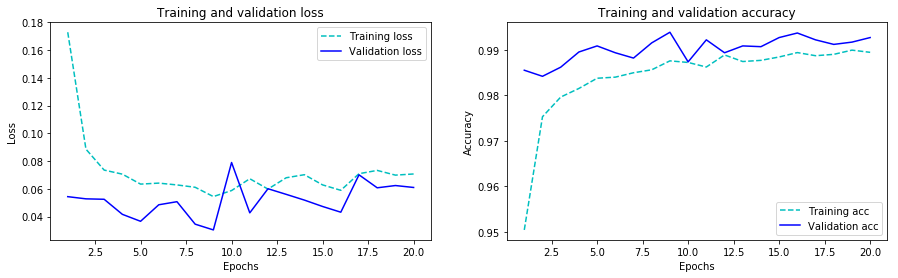

In [30]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr20.h5')
show_result(history)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 86s 2ms/step - loss: 0.0758 - acc: 0.9897 - val_loss: 0.0748 - val_acc: 0.9928
Epoch 2/10
54000/54000 [==============================] - 85s 2ms/step - loss: 0.0881 - acc: 0.9896 - val_loss: 0.0777 - val_acc: 0.9915
Epoch 3/10
54000/54000 [==============================] - 85s 2ms/step - loss: 0.0825 - acc: 0.9898 - val_loss: 0.0671 - val_acc: 0.9922
Epoch 4/10
54000/54000 [==============================] - 85s 2ms/step - loss: 0.0942 - acc: 0.9897 - val_loss: 0.0682 - val_acc: 0.9935
Epoch 5/10
54000/54000 [==============================] - 86s 2ms/step - loss: 0.1257 - acc: 0.9886 - val_loss: 0.0947 - val_acc: 0.9917
Epoch 6/10
54000/54000 [==============================] - 85s 2ms/step - loss: 0.1296 - acc: 0.9891 - val_loss: 0.0989 - val_acc: 0.9928
Epoch 7/10
54000/54000 [==============================] - 85s 2ms/step - loss: 0.1493 - acc: 0.9883 - val_loss: 0.1071 - val_acc:

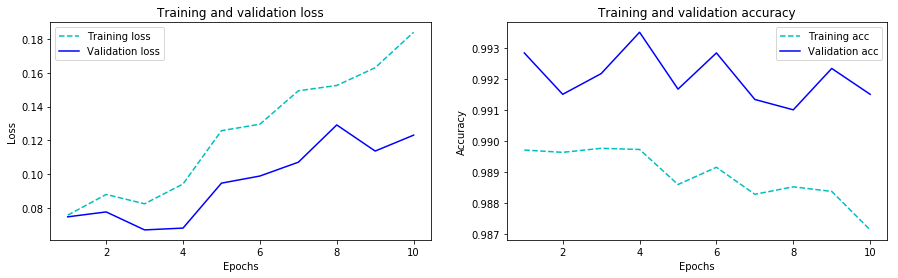

In [31]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr30.h5')
show_result(history)

Last train accuracy: 0.9895555555908768
Last validation accuracy: 0.992


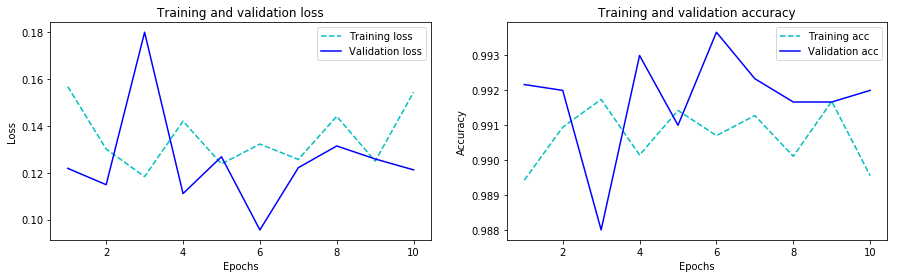

In [33]:
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=False)
cnn.save('baseline_model_itr40.h5')
show_result(history)

Last train accuracy: 0.9907962963139569
Last validation accuracy: 0.9931666666666666


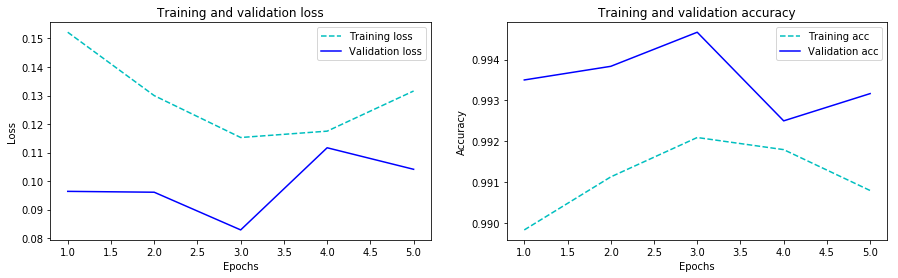

In [34]:
cnn = models.load_model('baseline_model_itr30.h5')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stop],
                  verbose=False)
cnn.save('baseline_model_itr40_earlystop.h5')
show_result(history)

### 5. Evaluate your model 
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [36]:
pred_class = evaluation_report(cnn,X_test,y_test)

[[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1129    1    2    0    2    0    1    0    0]
 [   0    0 1025    1    0    0    1    4    1    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    1    0    0  969    0    2    1    7    2]
 [   1    0    0    2    0  888    1    0    0    0]
 [   3    2    0    0    1    3  947    0    2    0]
 [   0    1    2    0    0    1    0 1023    1    0]
 [   1    0    0    1    0    2    0    0  969    1]
 [   0    1    0    2    1    2    0    2    8  993]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       980
          1       1.00      0.99      1.00      1135
          2       1.00      0.99      0.99      1032
          3       0.99      1.00      0.99      1010
          4       1.00      0.99      0.99       982
          5       0.99      1.00      0.99       892
          6       1.00      0.99      0.99       958
          7       0.99      1.00      0.99  

### 6.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(73, 28, 28)


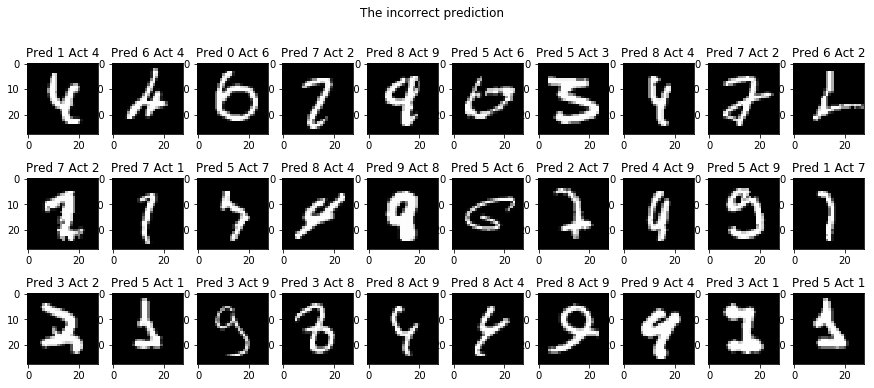

In [46]:
show_false_prediction(pred_class, X_test, y_test)

**Discuss the results**

*Discussion*

### 5. Data Augmentation 

Using the ```ImageDataGenerator``` module to generate more data. This technique is called data augmentation. It help generate more variation of the data which help prevent overfit and generalize better.

Lookup in the Keras document to see what method does it provide. https://keras.io/preprocessing/image

Becasue we want to build a data generator object, we have to re-load the data and specify rescale argument in ImageDataGenerator module.

In [75]:
# Re-load the image data
(X_train,y_train), (X_test,y_test) = mnist.load_data()

# Because the ImageDataGenerator require tensor of 4 dimension 
# Reshape data to 4 dimension (batch, width, height, channel)
def reshape_gray(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    return data

X_train = reshape_gray(X_train)
X_test = reshape_gray(X_test)

# split to validation set and train set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [76]:
# update global variable
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

BATCH_SIZE = 32

In [77]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [89]:
# Create an Iterator object. 
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

Last train accuracy: 0.9381111111111111
Last validation accuracy: 0.911


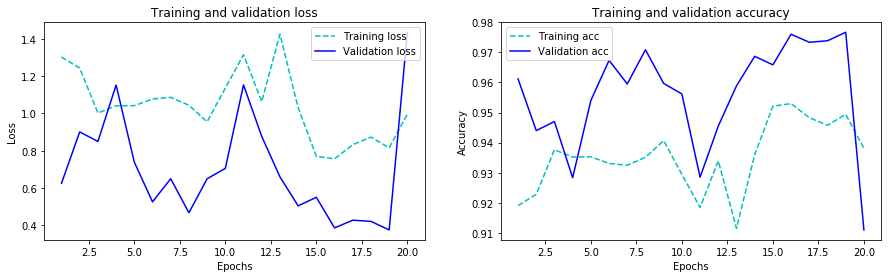

In [83]:
# Using fit_generator to train your model. We don't need to specify the batch size since we already done that when we create Iterator
history = cnn.fit_generator(train_generator, 
                              epochs=20, 
                              verbose=0, 
                              callbacks=None, 
                              validation_data=validate_generator,
                              workers=8, use_multiprocessing=True)
cnn.save('baseline_model_itr60_data_aug.h5')
show_result(history)

Last train accuracy: 0.9419074074074074
Last validation accuracy: 0.9695


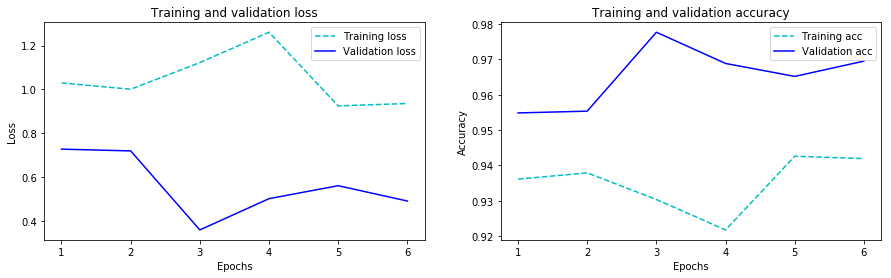

In [86]:
# Add early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Load previos model
cnn = models.load_model('baseline_model_itr60_data_aug.h5')


history = cnn.fit_generator(train_generator, 
                              epochs=20, 
                              verbose=0, 
                              callbacks=[early_stop], 
                              validation_data=validate_generator)

cnn.save('baseline_model_itr60_data_aug_earlystop.h5')
show_result(history)

Last train accuracy: 0.9397962962962964
Last validation accuracy: 0.9693333333333334


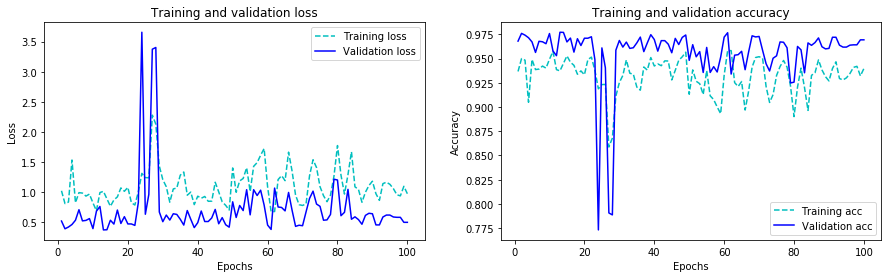

In [87]:
# Let it run
history = cnn.fit_generator(train_generator, 
                              epochs=100, 
                              verbose=0, 
                              validation_data=validate_generator)

cnn.save('baseline_model_itr160_data_aug.h5')
show_result(history)

In [88]:
pred_class = evaluation_report(cnn,X_test,y_test)

[[ 950    0    6    1    3    6    8    4    2    0]
 [   0 1066    4    4   43    7    3    4    4    0]
 [   1    0  996   17    0    1    0   13    4    0]
 [   0    0    0 1001    0    7    0    1    1    0]
 [   0    0    1    1  957    1    0    3    2   17]
 [   0    0    0    7    0  884    0    0    0    1]
 [   1    1    1    0    9   28  912    0    6    0]
 [   0    0   20   11    3    0    0  994    0    0]
 [   2    0    3    7    7   10    0    4  931   10]
 [   1    1    0    6   13   17    0   16    5  950]]
             precision    recall  f1-score   support

          0       0.99      0.97      0.98       980
          1       1.00      0.94      0.97      1135
          2       0.97      0.97      0.97      1032
          3       0.95      0.99      0.97      1010
          4       0.92      0.97      0.95       982
          5       0.92      0.99      0.95       892
          6       0.99      0.95      0.97       958
          7       0.96      0.97      0.96  

### 6. Visualize Layer Activation 
**Note:** the function is defined above.

In [ ]:
### Feed your model and number of layer you want to show 

show_layer_activation(model,num_layer)

**What do you think the network can detect?**
- Discuss

### 7. Visualize What The Model See

In [ ]:
### Feed your model and layer name, ie. 'conv_1', that you want to show.

visualize_filter(model,layer_name)

**What do you think the network see?**
- Discuss

### 8. Transfer Learning 
- What is transfer learning https://towardsdatascience.com/transfer-learning-946518f95666
- which transfer learning method to use https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

The following is a tutorial code to load and freeze some layer. Keras also come with a build-in pre-train network on imageNet dataset (See www.image-net.org)

Keras Pre-train Network https://keras.io/applications

#### 8.1.1 Use Build-in Pre-train Network
Keras come with a build-in pre-train network that let you download and use it in your problem. You can import only model structure or import neuron weight that had been train on imageNet.

In [ ]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(150,150,3))

In [ ]:
vgg.summary()

#### 8.1.2 Use Our Pre-train Network

When we are doing the deep learning/machine learning project, sometime, we may encounter a similar problem. After several project, we will have many existing model that we experiment and develop. We can used these model as a pre-train network to solve a new problem. This can save a hugh cost (time and money) and jump start our new project very quickly.

In [ ]:
prev_cnn = models.load_model('your_previos_model.h5')
prev_cnn.summary()

In [ ]:
# Use .pop() to remove the last layer
# In this case, we want to remove last two layer

prev_cnn.pop()
prev_cnn.pop()

In [ ]:
# See how our model change
prev_cnn.summary()

For both method, if you want to change input size of your network, you have to create a model using functional API.
See https://keras.io/models/model

#### 8.2.1 Freezing layer - All

In [ ]:
# If we don't want to train these layer, we have to freeze these layer. 
# Note that if we want a pre-train as a weight initializer, we don't have to freeze the layer.

prev_cnn.trainable = False

#### 8.2.2 Freezing layer - Specific layer

In [ ]:
# Freeze a specific layers
# Freeze first 3 layer
for i in range(3):
    prev_cnn.layers[i].trainable = False

#### 8.3 Connnect your model

In [ ]:
# Time to create a new model
new_cnn = models.Sequential()

# Add convolutional layer as a pre-train network
new_cnn.add(prev_cnn)

# Define fully-connect layer
new_cnn.add(layers.Dense(256,activation='elu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(10,activation='softmax',name='output'))

# Show how your network looklike
new_cnn.summary()

After this process, you can use your network as the way you like. 

### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method (we are not using build-in data anymore!)
2. You have to plan on how you will split a data.
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!